In [14]:
import pandas as pd
import numpy as np

In [15]:
df=pd.read_csv('ecommerce_returns_synthetic_data.csv')
df

,Order_ID,Product_ID,User_ID,Order_Date,Return_Date,Product_Category,Product_Price,Order_Quantity,Return_Reason,Return_Status,Days_to_Return,User_Age,User_Gender,User_Location,Payment_Method,Shipping_Method,Discount_Applied
0,ORD00000000,PROD00000000,USER00000000,2023-08-05,2024-08-26,Clothing,411.59,3,Changed mind,Returned,387.0,58,Male,City54,Debit Card,Next-Day,45.27
1,ORD00000001,PROD00000001,USER00000001,2023-10-09,2023-11-09,Books,288.88,3,Wrong item,Returned,31.0,68,Female,City85,Credit Card,Express,47.79
2,ORD00000002,PROD00000002,USER00000002,2023-05-06,NaN,Toys,390.03,5,NaN,Not Returned,NaN,22,Female,City30,Debit Card,Next-Day,26.64
3,ORD00000003,PROD00000003,USER00000003,2024-08-29,NaN,Toys,401.09,3,NaN,Not Returned,NaN,40,Male,City95,PayPal,Next-Day,15.37
4,ORD00000004,PROD00000004,USER00000004,2023-01-16,NaN,Books,110.09,4,NaN,Not Returned,NaN,34,Female,City80,Gift Card,Standard,16.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,ORD00009995,PROD00009995,USER00009995,2023-10-20,NaN,Home,142.50,4,NaN,Not Returned,NaN,37,Male,City40,PayPal,Standard,34.27
9996,ORD00009996,PROD00009996,USER00009996,2023-02-25,NaN,Electronics,484.63,3,NaN,Not Returned,NaN,69,Male,City62,Debit Card,Express,25.44
9997,ORD00009997,PROD00009997,USER00009997,2024-05-10,NaN,Toys,386.57,5,NaN,Not Returned,NaN,46,Male,City74,Credit Card,Next-Day,12.67
9998,ORD00009998,PROD00009998,USER00009998,2024-02-13,NaN,Toys,129.22,1,NaN,Not Returned,NaN,34,Female,City34,Gift Card,Express,49.97


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Order_ID          10000 non-null  object 
 1   Product_ID        10000 non-null  object 
 2   User_ID           10000 non-null  object 
 3   Order_Date        10000 non-null  object 
 4   Return_Date       5052 non-null   object 
 5   Product_Category  10000 non-null  object 
 6   Product_Price     10000 non-null  float64
 7   Order_Quantity    10000 non-null  int64  
 8   Return_Reason     5052 non-null   object 
 9   Return_Status     10000 non-null  object 
 10  Days_to_Return    5052 non-null   float64
 11  User_Age          10000 non-null  int64  
 12  User_Gender       10000 non-null  object 
 13  User_Location     10000 non-null  object 
 14  Payment_Method    10000 non-null  object 
 15  Shipping_Method   10000 non-null  object 
 16  Discount_Applied  10000 non-null  float64

In [17]:
df.nunique()

Order_ID            10000
Product_ID          10000
User_ID             10000
Order_Date            731
Return_Date           729
Product_Category        5
Product_Price        9074
Order_Quantity          5
Return_Reason           4
Return_Status           2
Days_to_Return       1249
User_Age               53
User_Gender             2
User_Location         100
Payment_Method          4
Shipping_Method         3
Discount_Applied     4317
dtype: int64

In [18]:
df=df.drop(columns=['Order_ID','Product_ID','User_ID','Order_Date','Return_Date','User_Location','User_Gender'],axis=1)

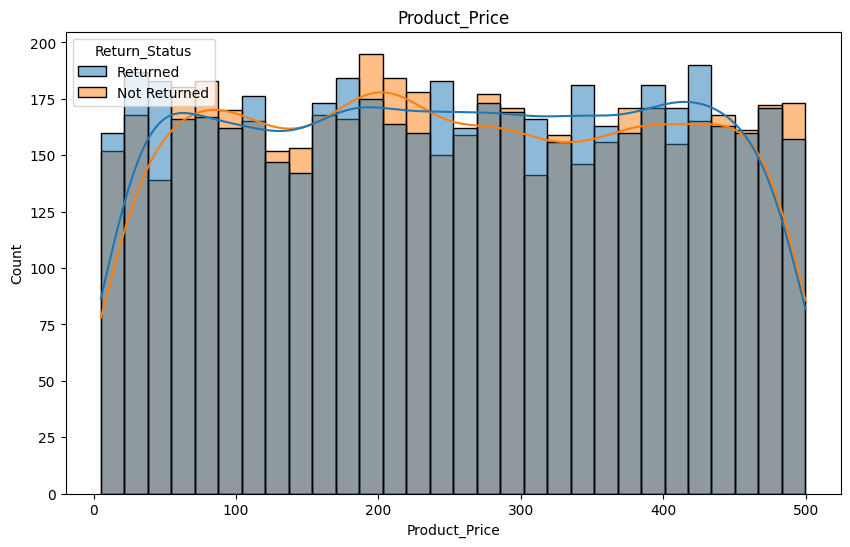

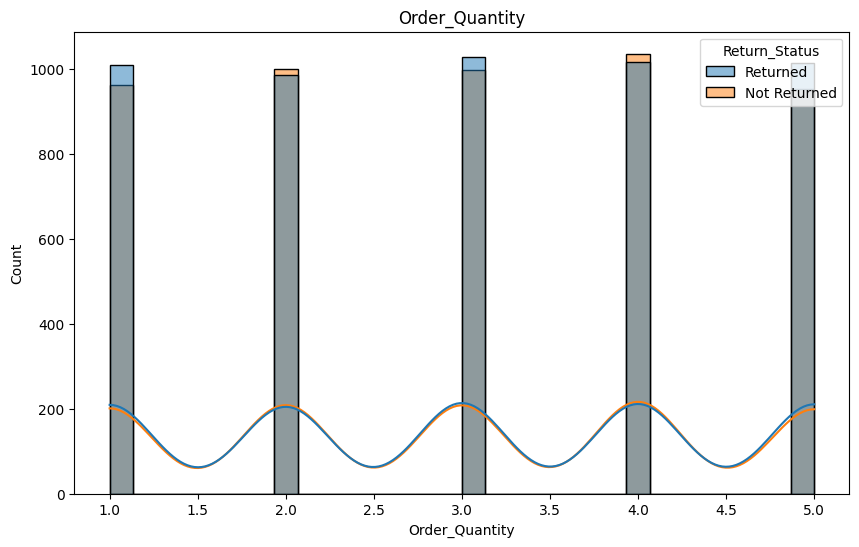

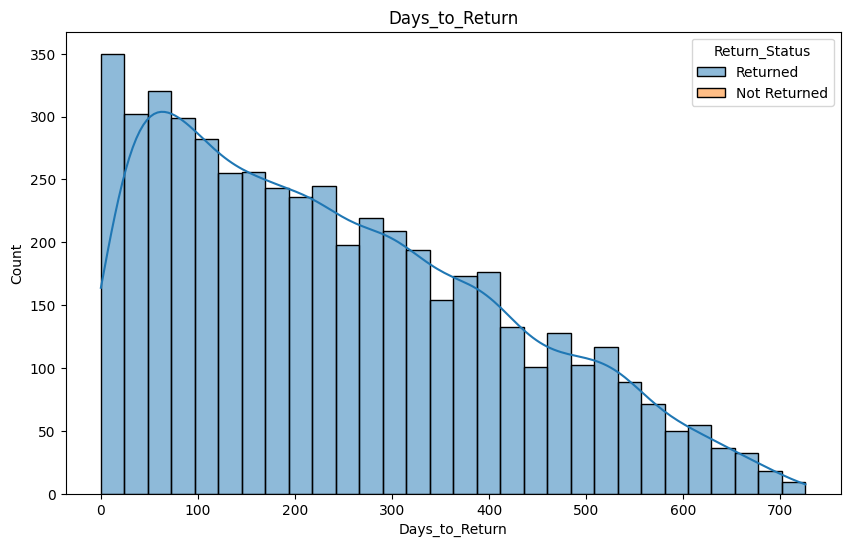

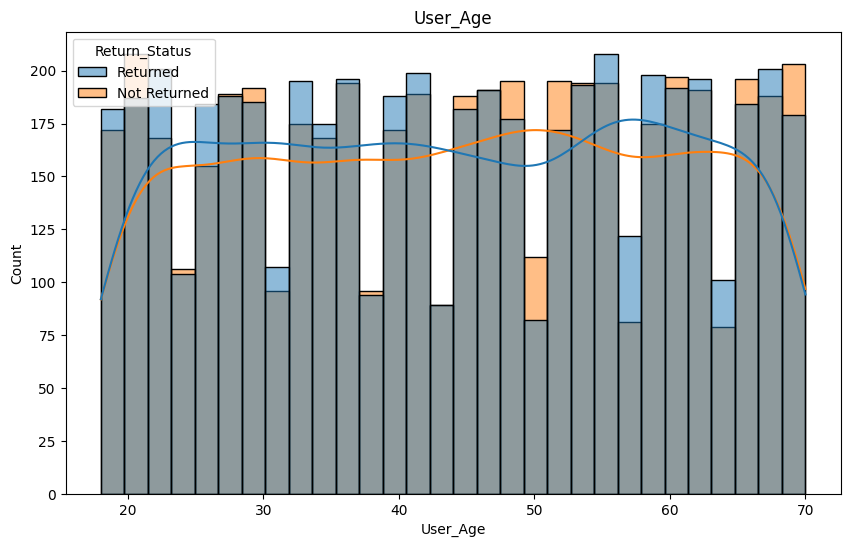

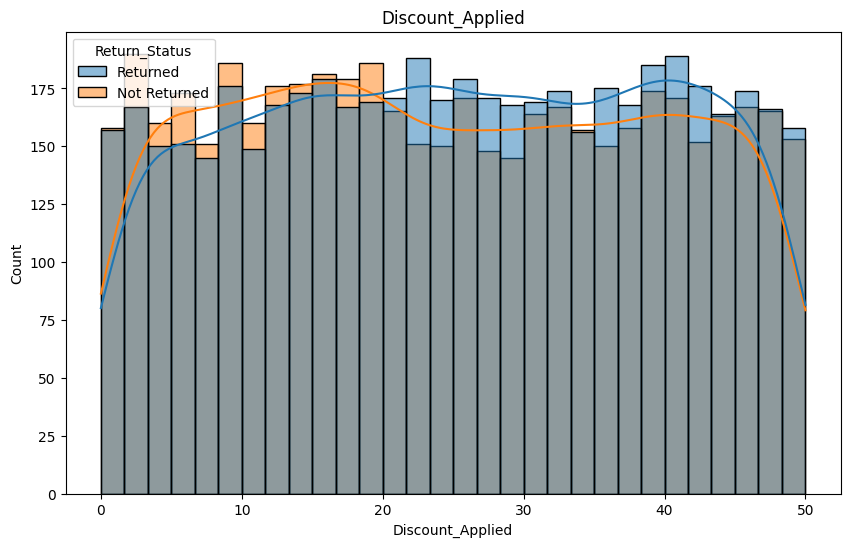

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
num_cols=df.select_dtypes(include=['int64','float64']).columns
df['Days_to_Return']=abs(df['Days_to_Return'])
for col in num_cols:
    plt.figure(figsize=(10,6))
    sns.histplot(data=df, x=col, hue='Return_Status', bins=30,common_norm=False, kde=True)
    plt.title(col)
    plt.show()


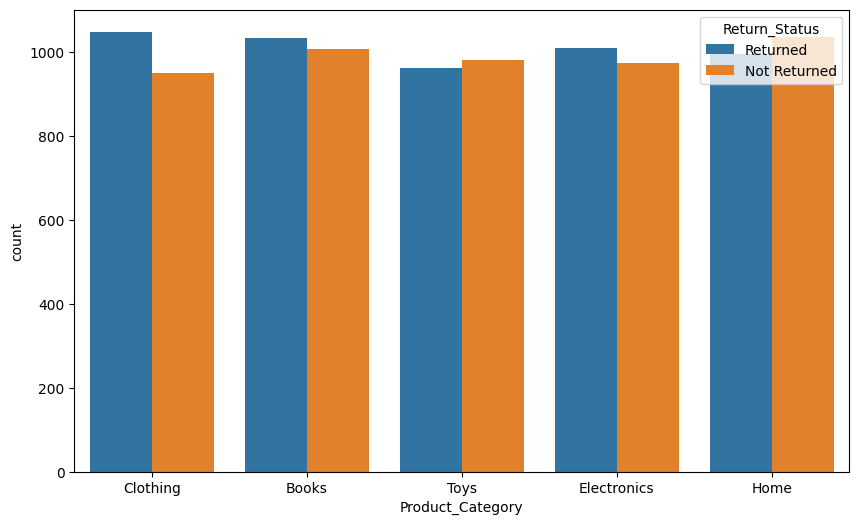

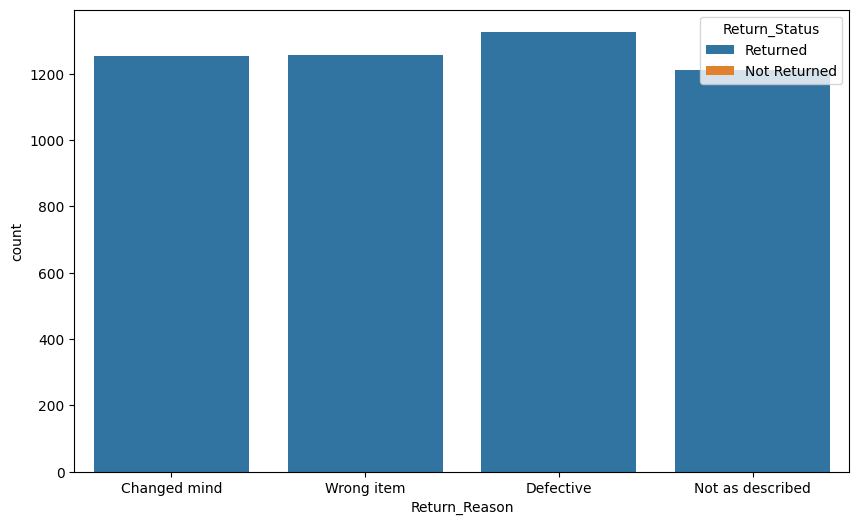

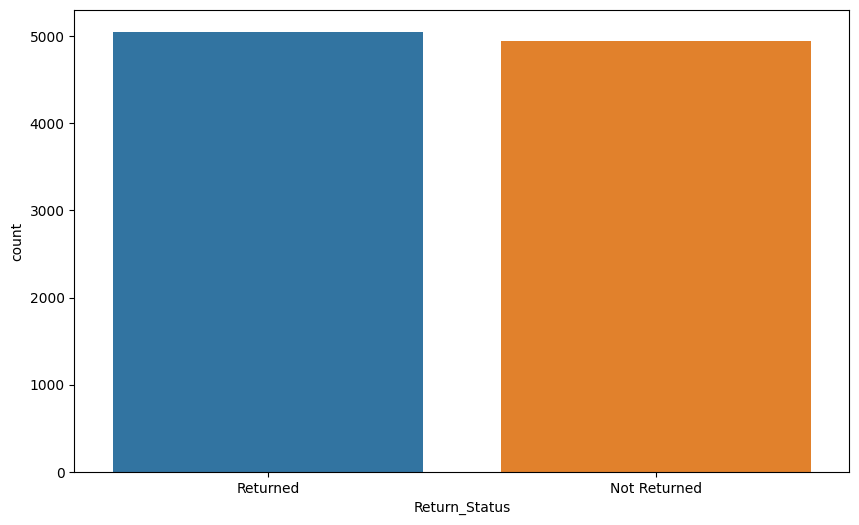

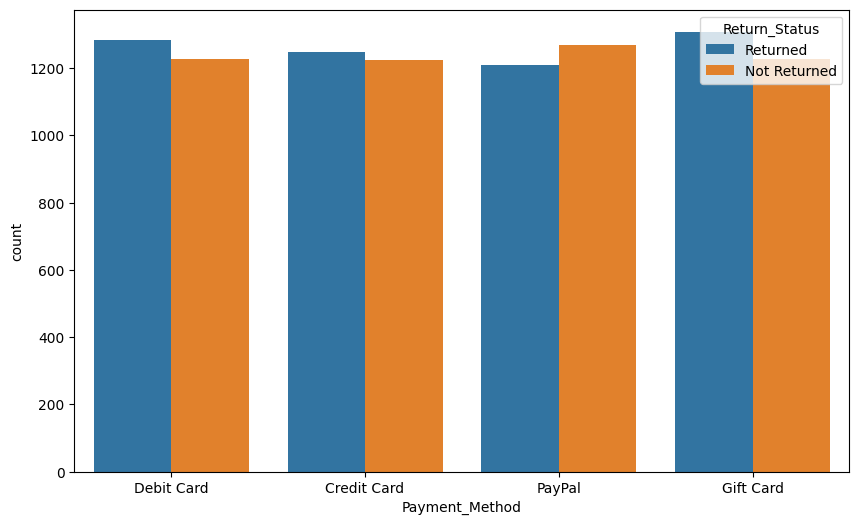

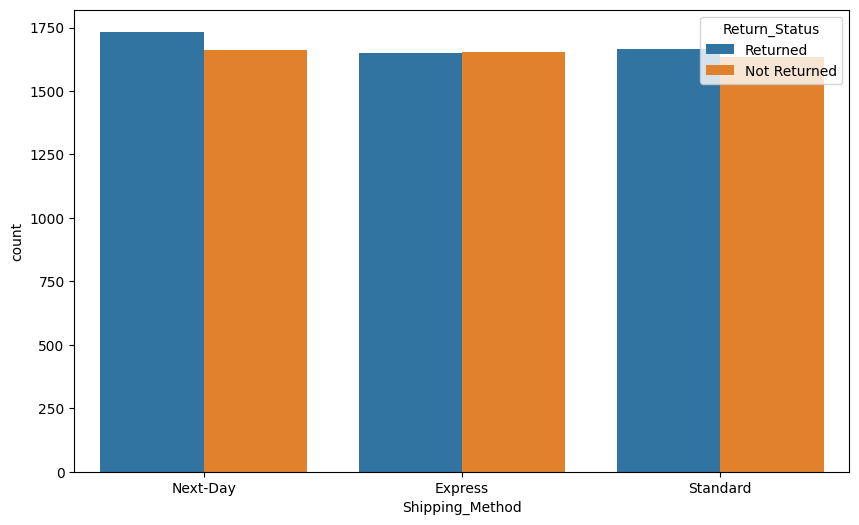

In [20]:
al_cols=df.select_dtypes(include=['object']).columns
for col in al_cols:
    plt.figure(figsize=(10,6))
    sns.countplot(data=df,x=col,hue='Return_Status')
    plt.show()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


df_split=pd.get_dummies(df.drop(columns=['Return_Status','Return_Reason','Days_to_Return'],axis=1),drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(df_split, df['Return_Status'].replace({
'Returned':1, 'Not Returned':0  
}), test_size=0.2, random_state=42)   

C:\Users\Rishi\AppData\Local\Temp\ipykernel_12016\3923948015.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train, X_test, y_train, y_test = train_test_split(df_split, df['Return_Status'].replace({


In [22]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score,f1_score
rf=RandomForestClassifier()
param_grid={
    'n_estimators':[100,200,300,400,500],
    'min_samples_leaf':[1,3,5,7,9],
    'min_samples_split':[2,4,6,8,10],
    'max_depth':[None,10,20,30,40,50]
}

rf_tuning=RandomizedSearchCV(estimator=rf,param_distributions=param_grid,n_iter=10,cv=3,verbose=2,random_state=42,n_jobs=-1,scoring='f1')
rf_tuning.fit(X_train,y_train)
print("Tuned Decision Tree Parameters: {}".format(rf_tuning.best_params_))
# print("Best score is {}".format(rf_tuning.best_score_))
# y_pred=rf_tuning.best_estimator_.predict(X_test)
# print(classification_report(y_test,y_pred))
# print(accuracy_score(y_test,y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuned Decision Tree Parameters: {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 10}


In [25]:
y_prob=rf_tuning.best_estimator_.predict_proba(X_test)[:,1]
thresholds=np.arange(0.01,0.99,0.01)
f1_scores=0
best_threshold=0
for t in thresholds:
    y_pred=(y_prob>=t).astype(int)
    if accuracy_score(y_test,y_pred)>f1_scores:
        f1_scores=accuracy_score(y_test,y_pred)
        best_threshold=t
best_threshold, f1_scores

(np.float64(0.55), 0.5085)

In [26]:
y_prob_test=rf_tuning.best_estimator_.predict_proba(X_test)[:,1]
y_pred_test=(y_prob_test>=best_threshold).astype(int)

print(classification_report(y_test,y_pred_test))
print(accuracy_score(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.51      0.81      0.63      1009
           1       0.51      0.20      0.29       991

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.46      2000
weighted avg       0.51      0.51      0.46      2000

0.5085
